# Klasyfikacja tweetów Elona Muska

### Projekt realizuje grupa:

*  Wiktor Bajor **249459**
*  Adam Kubiak **249480**


### Opis wykonywanego zadania: 

&nbsp; W ramach projektu grupa będzie realizować zadanie klasyfikacji binarnej tweetów Elona Muska. Wykonywane zadanie będzie opierać się o zebranie tweetów sławnych ludzi, takich jak politycy, przedsiębiorcy, sportowcy, celebryci, influencerzy oraz Elon Musk. 
Akwizycja danych będzie realizowana poprzez publiczny interfejs programowania aplikacji (API), udostępniony przez Twitter.  Przy czym możliwa ilość tweetów do pobrania to pięćset tysięcy, co powinno być wystarczającą ilością danych. Dzięki udostępnionemu API można uzyskać dostęp do takich danych jak, treść publikacji, godzina publikacji, lokalizacja, ilość polubień czy ilość retweetów. Po ukończeniu etapu akwizycji danych kolejnym zadaniem, będzie przeanalizowanie tweetów, mając na uwadze takie elementy jak ilość retweetów, ilość polubień, występowanie pewnych słów kluczowych czy też sentyment umieszczonego tekstu. Na podstawie dokonanej analizy zostaną wybrane najbardziej charakterystyczne cechy tweetów Elona Muska. Ostatnim elementem projektu będzie utworzenie i wytrenowanie (na bazie wcześniej wybranych najbardziej istotny cech) klasyfikatora, który będzie oceniał czy dany tweet był napisany przez Elona Muska czy też nie. Wykonana analiza oraz klasyfikator mogłyby zostać wykorzystane do stworzenia cyfrowego sobowtóra Elona Muska. 

In [20]:
import tweepy
import configparser
import pandas as pd
from textblob import TextBlob
import re
import matplotlib.pyplot as plt


def get_all_access_configs():
    config = configparser.RawConfigParser()
    config.read('config.ini')
    config = config['twitter']

    return config.values()

_, _, _, _, bearer_token = get_all_access_configs()

client = tweepy.Client(bearer_token)


In [73]:
user = 'elonmusk'

def fetch_tweets_from_user(user, client):
    id = client.get_user(username=user)
    tweet_fields=['author_id', 'created_at', 'public_metrics', 'text', 'source', 'possibly_sensitive', 'lang', 'entities', 'context_annotations']

    paginator = tweepy.Paginator(
        method = client.get_users_tweets,
        id = str(id.data.id),
        exclude=['retweets', 'replies'],
        tweet_fields=tweet_fields)

    return [ tweet for tweet in paginator.flatten()]

tweets = fetch_tweets_from_user(user, client)


In [59]:
def is_elon_musk_tweet(tweet):
    elon_musk_id = 44196397
    return [tweet.author_id == elon_musk_id]

def clean_tweet(tweet):
    return re.sub(r"http\S+", "", tweet)

def get_tweet_sentiment(tweet):  
        analysis = TextBlob(clean_tweet(tweet.text))
        return [analysis.sentiment.polarity]

def get_basic_tweet_data(tweet):
    elon_musk_id = 44196397
    return [tweet.author_id == elon_musk_id, tweet.created_at, clean_tweet(tweet.text), tweet.source, tweet.possibly_sensitive, tweet.lang]

def get_public_metrics(tweet):
    return tweet.public_metrics.values()

def connect_generated_tweets_data(tweet, functions):
    data_row = []
    for function in functions:
        data_row.extend(function(tweet))
    return data_row

def make_pd_data_frame(tweets, columns, tweet_data_extract_functions):
    data_rows = [ connect_generated_tweets_data(tweet, tweet_data_extract_functions) for tweet in tweets]
    df = pd.DataFrame(data=data_rows, columns=columns)
    df.to_csv('user_data/%s_tweets.csv' % user,index=False)

    return df


In [74]:
columns=[
    'is Elon musk',
    'created at',
    'text',
    'source',
    'possibly sensitive',
    'lang',
    'sentiment',
    'retweet count',
    'reply count',
    'like count',
    'quote count']
    
tweet_data_extract_functions = [get_basic_tweet_data, get_tweet_sentiment, get_public_metrics]

data_frame = make_pd_data_frame(tweets, columns, tweet_data_extract_functions)
data_frame.head(len(tweets))

,is Elon musk,created at,text,source,possibly sensitive,lang,sentiment,retweet count,reply count,like count,quote count
0,True,2022-10-30 11:48:04+00:00,But Management 201 is such a tantalizing carrot …,Twitter for iPhone,False,en,0.000,987,1796,31550,96
1,True,2022-10-30 11:42:56+00:00,So demanding to allow a mere 30 days to learn ...,Twitter for iPhone,False,en,0.250,1556,1887,39019,89
2,True,2022-10-30 11:25:19+00:00,Just received this email from Twitter. This is...,Twitter for iPhone,False,en,0.100,11367,13253,135325,1782
3,True,2022-10-29 17:36:31+00:00,#SoBrave,Twitter for iPhone,False,qht,0.000,5118,4990,118964,299
4,True,2022-10-29 17:35:45+00:00,"Finally, the truth that carbs are amazing can ...",Twitter for iPhone,False,en,0.375,45281,37672,564226,6259
...,...,...,...,...,...,...,...,...,...,...,...
701,True,2022-01-30 08:26:30+00:00,,Twitter for iPhone,False,zxx,0.000,34477,10144,388227,2533
702,True,2022-01-29 23:39:10+00:00,Just rewatched True Romance ♥️,Twitter for iPhone,False,en,0.350,6461,10918,109108,853
703,True,2022-01-29 11:21:38+00:00,Lie back and think of Mars,Twitter for iPhone,False,en,0.000,15879,23640,199592,2408
704,True,2022-01-29 06:48:49+00:00,,Twitter for iPhone,False,zxx,0.000,23216,10860,215254,2459


In [68]:
def get_value_from_dict(tweet, name='annotations'):
    dict = tweet.entities
    if dict is not None:
        dict = dict.get(name)
        if dict is not None:
            return  [ dict[0]['probability'], dict[0]['normalized_text'], dict[0]['type'] ]
    return [None]

def get_context_annotations_domain_value(tweet, context_annotations_number=0, key='domain'):
    context_annotations = tweet.context_annotations

    if len(context_annotations) > context_annotations_number:
        return context_annotations[context_annotations_number][key]['name']
    return None

def create_columns_for_annotations_data(number_of_instances=6):
    annotations_columns = ['is Elon Musk']
    for i in range(number_of_instances):
        annotations_columns.extend([f'context annotations domain {i}', f'context annotations entity {i}'])
    
    annotations_columns.append('annotations')
    return annotations_columns
    
def get_all_annotations_data(tweet, number_of_instances=6):
    annotations_data = []
    for i in range(number_of_instances):
        annotations_data.extend([
            get_context_annotations_domain_value(tweet, i),
            get_context_annotations_domain_value(tweet, i, 'entity')])
    
    return annotations_data

columns = create_columns_for_annotations_data()

tweet_data_extract_functions = [is_elon_musk_tweet, get_all_annotations_data, get_value_from_dict]

data_frame_annotation = make_pd_data_frame(tweets, columns, tweet_data_extract_functions)
data_frame_annotation.head(len(tweets))


,is Elon Musk,context annotations domain 0,context annotations entity 0,context annotations domain 1,context annotations entity 1,context annotations domain 2,context annotations entity 2,context annotations domain 3,context annotations entity 3,context annotations domain 4,context annotations entity 4,context annotations domain 5,context annotations entity 5,annotations
0,True,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,None


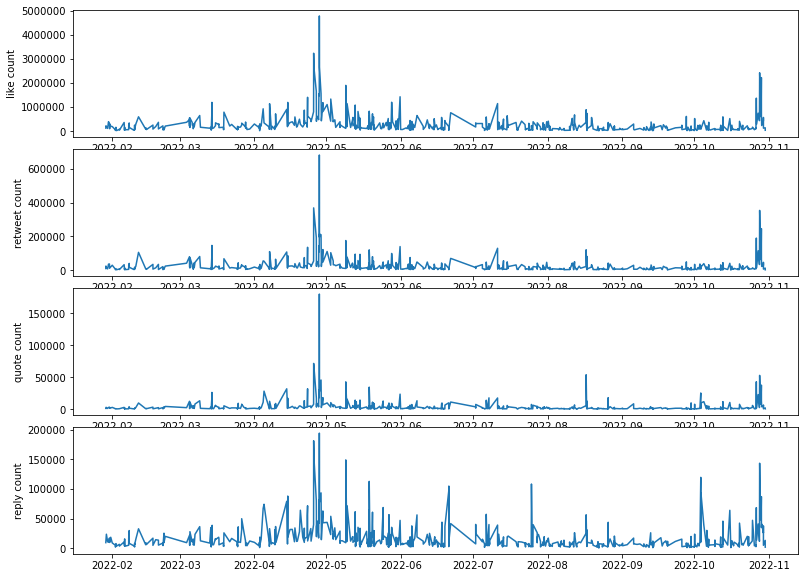

In [82]:
ylabels = ["like count","retweet count", 'quote count', 'reply count']

fig = plt.figure(figsize=(13,10))
fig.subplots_adjust(hspace=0.1,wspace=0.01)

n_row = len(ylabels)
n_col = 1
for count, ylabel in enumerate(ylabels):
    ax = fig.add_subplot(n_row,n_col,count+1)
    ax.plot(data_frame["created at"], data_frame[ylabel].to_numpy())
    ax.set_ylabel(ylabel)
plt.show()